In [1]:
from elasticsearch import Elasticsearch, helpers
from elasticsearch_dsl import Search

import numpy
import pandas
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

In [2]:
# 
ELASTIC_SERVER_SOCKET = '192.168.56.101:9200'
elastic_client = Elasticsearch([ELASTIC_SERVER_SOCKET])

In [3]:
search = Search(using=elastic_client, index="bro-2017.11.29").query('exists', field='conn.orig_bytes')

In [4]:
bandwidth = []
# I am limiting the number of documents so that this runs comfortably on an overworked laptop
max_documents = 10000 
count = 0
for document in search.scan():
    if count >= max_documents:
        break
    else:
        count += 1
    try:
        up = document['conn']['orig_bytes']
        down = document['conn']['resp_bytes']
        
        bandwidth.append((up,down))
        
    except Exception as e:
         print(e)

In [5]:
# Notice that this time instead of a dataframe our data is a list of tuples. 
# Most libraries in the Python data science universe will accept native Python lists, tuples and dictonaries. 
# These will be converted internally to Pandas dataframes or Numpy arrays. 
scaled_data = StandardScaler().fit_transform(bandwidth)

In [6]:
# DBSCAN was chosen for this demo because it both clusters and identifies anomalies. 
# DBSCAN requires an inter-clister distence. Points less than that distence merge together. 
# After merging is complete and clusters with less than the minamum sample count are considered anomalies. 
clusters =  DBSCAN(eps=1.5, min_samples=10).fit_predict(scaled_data)

In [7]:
unique_labels = set(clusters)

In [8]:
colors = [plt.cm.Spectral(each) for each in numpy.linspace(0, 1, len(unique_labels))]

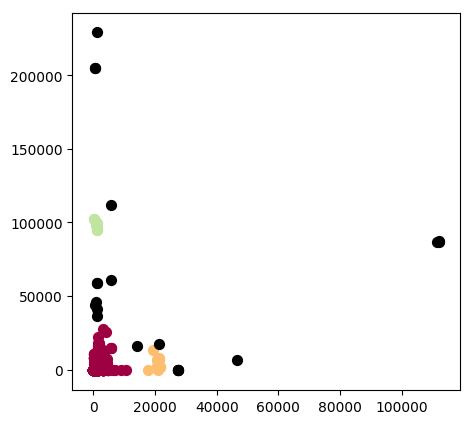

In [9]:
fig=plt.figure(figsize=(5, 5), dpi=100, facecolor='w', edgecolor='k')
for item, prediction in zip(bandwidth, clusters):
    if prediction == -1:
        color = 'k' # 'k' is the code for black in matplotlib 
    else:
        color = colors[prediction] 
        
    plt.scatter(item[0], item[1], c=[color], s=50)
    
plt.show()
# We can see that DBSCAN was able to identify areas with few points. 
# These are less common occurences that may be worth following up on. 